# Bioinformatics Test

## Transcription Binding Site Prediction

In this notebook, I will be trying to identify the location of the most probable binding site for the MYC transcription factor (TF). 
MYC is a phosphoprotein that plays a role in cell cycle progression, apoptosis and cellular transformation. The MYC gene is a known proto-oncogene that is commonly deregulated in human cancer [Citation 1](https://www.genecards.org/cgi-bin/carddisp.pl?gene=MYC) and is a promising target for future anti-mitotic therapies [Citation 2](https://www.nature.com/articles/s41392-018-0008-7). To accomplish this, I have the full sequence of bases for chromosome 1, and a position frequency matrix for each base at the binding site. Converting the PFM to a position weight matrix allows us to calculate the score of every transcription frame along the length of chromosome and compare the values to identify the position of highest probable binding.

In [59]:
# First some libraries to help, keeping this to a minimum.

import pandas as pd # dataframe and structures I can't access in base
import math # standard math libray
from collections import deque # one import from the standard col library
from itertools import tee # import tee for creating a sliding window.
from Bio import SeqIO # to read the fasta file
import seqlogo # only for plotting seq logo

%matplotlib inline

### To minimize the library overhead I am going to recreate the PFM manually. 

It's a 12x4 matrix which denotes the frequency at which each base appears at each position of the binding site, which can be used to predict the likelihood of binding at any given sequence of bases [Citation 3](https://www.cs.cmu.edu/~02710/Lectures/Motifs2015.pdf). As this is just the frequencies and these scores are not scaled or relative, they need to be converted to a scale that conveys the relative importance of each base at each position as a function of the frequency.

In [5]:
df = pd.DataFrame([[1038,1019,438,44,4600,54,169,59,23,419,961,755],
              [1345,1287,3746,4840,59,4525,157,162,56,2801,1524,1785], 
              [1649,1757,472,31,170,70,4578,63,4817,1198,1036,1348],
              [910,879,286,27,113,293,38,4658,46,524,1421,1054]])
df # this represents the 12 positions the TSF can bind 
   # and the frequency it binds each position with a given base.

0     1     2     3     4     5     6     7     8     9    10    11
0  1038  1019   438    44  4600    54   169    59    23   419   961   755
1  1345  1287  3746  4840    59  4525   157   162    56  2801  1524  1785
2  1649  1757   472    31   170    70  4578    63  4817  1198  1036  1348
3   910   879   286    27   113   293    38  4658    46   524  1421  1054

### Create a function to convert the PFM values into PWM

A position weight matrix can be created from the PFM using the following equation [Citation 4](https://www.nature.com/articles/nrg1315):

$W_{b,i} = log_2\frac{p(b,i)}{p(b)}$

Here $W_{b,i}$ is the PWM value for a base, $b$ at position, $i$. The PWM value can be calculated as the $log_2$ product of the probability of a base at that position as a frequency, $p(b,i)$, divided by the overall probability of that base, $p(b)$.

In [6]:
def create_pwm(f,bg=0.25):
    p = math.log2(((f + (math.sqrt(8)*.25))/(8+(4*math.sqrt(8)*.25)))/bg)
    return(p)

pwm = df.applymap(create_pwm)
pwm.rename(index={0:'A',1:'C',2:'G',3:'T'}, inplace=True)
pwm

0         1          2          3          4          5          6  \
A  8.583821  8.557187   7.340362   4.045680  10.730888   4.336905   5.970151   
C  8.957397  8.893837  10.434656  10.804250   4.463079  10.707176   5.864352   
G  9.251242  9.342727   7.448051   3.549983   5.978628   4.707032  10.723973   
T  8.394092  8.344128   6.726682   3.355432   5.392427   6.761483   3.837775   

           7          8          9        10        11  
A   4.463079   3.130496   7.276487  8.472702  8.124932  
C   5.909382   4.388706  10.015339  9.137565  9.365528  
G   4.556631  10.797379   8.790512  8.581041  8.960610  
T  10.748962   4.108818   7.598617  9.036657  8.605875

It is probably a good idea to test this quickly to ensure the result makes sense. I am going to create an arbitrary string of length 12 and use it to calculate a probability that the transcription factor will bind to that sequence.

In [34]:
seq = 'aaccggttacgt' 
seq = seq.upper()
strand = list(seq)
strand

['A', 'A', 'C', 'C', 'G', 'G', 'T', 'T', 'A', 'C', 'G', 'T']

The i'th entry of the list returns a letter we can subset the PWM. i is also the index for that base in the list and is also the column index in the PWM for the probability of that base in that position. In other words, lookup time should be constant and hopefully, very fast for eventually iterating over the first 100,000 sequence windows. 

In [33]:
pwm.loc[strand[0]].iloc[0] # probability of 'A' in position 0, should be ~8.583821

8.583821391621731

Therefore, grabbing the probability of a given base at a given position appears to work correctly. I will now wrap that up in a function to grab the probability of every base in the sequence, append the values to a new list, and sum the scores to provide a single value to represent each sequence. 

In [35]:
def SeqScore(x):
    out = [] # create and empty list
    x = list(x) # make sure the data is in a list
    for i in range(len(x)): # iterate over every entry of the list
        score_i = pwm.loc[x[i]].iloc[i] # the score for i is in position i,i of the PWM
        out.append(score_i) # append all of the values together
    return(sum(out)) # return the summed score as the output

In [36]:
x = SeqScore(strand)
x

93.98506091696416

It is probably a good idea to ensure that a different strand returns a different probability value. In this case, the same sequence reversed. If this returns the same value it would be indicative I have programmed something incorrectly. 

In [37]:
strand.reverse()
y = SeqScore(strand)
y

90.6533457111982

Time to read in the fasta of the reference genome. The first 10,000 bases are all N which signify unsequenced heterochromatin, so the first 100,000 bases start from 10,000:110,000. One of my library imports is "Biopython" because it makes reading in fasta files trivial.

In [38]:
with open("genome/Homo_sapiens.GRCh38.dna.chromosome.1.fa", "r") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        print(record.id) # check that there is only one chromosome present.

1


I have two options for calculating the values of a sliding window along the sequence - I can either do them in tandem or sequentially. I believe that wrapping loops in loops makes code unnecessarily complex and it is easier to test smaller functions. So I am going to create a list of sequence frames that start at base zero and go to base 11 and shift forward by one until they reach the end. This list of frames means I can write a simpler function to iterate over the list and return back a list of values.   

In [39]:
def window(iterable, size): # create a function window with arguments for a string and the frame size
    iters = tee(iterable, size) # split the iterable into chunks of size n
    for i in range(1, size): # for in this range
        for each in iters[i:]: # and for each iterable of size i 
            next(each, None) # retrieve the next iterator
    return zip(*iters) # zip them all together

Now I am going to instantiate an empty list and then populate that list with the outputs of the sliding window function.

In [40]:
output = []
for each in window(str(record.seq[10000:110000]), 12):
    output.append(list(each))

seq_df = pd.DataFrame(output) # at this point I am going to turn the list into a dataframe so I can use the pandas apply functions to create an output column.
seq_df.head() # this also let's me subset the dataframe to find the highest probability binding site and do some quit plotting.

0  1  2  3  4  5  6  7  8  9 10 11
0  T  A  A  C  C  C  T  A  A  C  C  C
1  A  A  C  C  C  T  A  A  C  C  C  T
2  A  C  C  C  T  A  A  C  C  C  T  A
3  C  C  C  T  A  A  C  C  C  T  A  A
4  C  C  T  A  A  C  C  C  T  A  A  C

Now I am going to create a column of the scores using the SeqScore function I created earlier. 

In [28]:
seq_df['score'] = seq_df.apply(SeqScore, axis=1)
seq_df.head()

0  1  2  3  4  5  6  7  8  9 10 11      score
0  T  A  A  C  C  C  T  A  A  C  C  C  90.215927
1  A  A  C  C  C  T  A  A  C  C  C  T  92.185191
2  A  C  C  C  T  A  A  C  C  C  T  A  91.891062
3  C  C  C  T  A  A  C  C  C  T  A  A  87.067804
4  C  C  T  A  A  C  C  C  T  A  A  C  91.058930

I can now subset the score column to find the maximum probability and return the index for the start of the transcription window and the sequence inside that frame. 

In [14]:
seq_df.iloc[seq_df['score'].idxmax(axis=0)]

0              G
1              A
2              C
3              C
4              A
5              C
6              G
7              T
8              G
9              C
10             T
11             G
score    120.768
Name: 25075, dtype: object

#### The location with the highest probability of binding by the MYC transcription factor starts at base 25075 and extends to 25086, indicating that the sequence of highest probability for transcription binding is GACCACGTGCTG.

At this point some exploration of the data is important to understand the context of the sequence, following which I will make some inferences about it and some suggestions for how to improve this analysis. First, the score for this sequence is 120.768, which is a unitless number except in the scale of other relative binding probabilities. So I will plot a kernel density estimate diagram to understand where this falls in the spectrum of values. 

87.8508490699986
71.34146873283291
120.7683185389549
6.8416939205142215


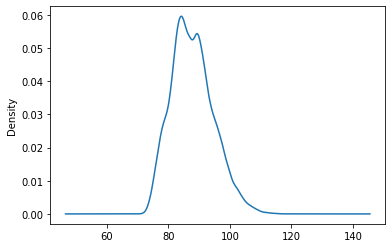

In [15]:
print(seq_df.score.mean()) 
print(seq_df.score.min())
print(seq_df.score.max())
print(seq_df.score.std())

s = pd.Series(seq_df['score'])
ax = s.plot.kde()

The mean relative likelihood is very clear at around 87.9 and the min and the max both fairly distant from the mean. However, the max value is greater than 5 standard deviations from the mean and the data is clearly long tailed, so it is inappropriate to assume this is a normal distribution.

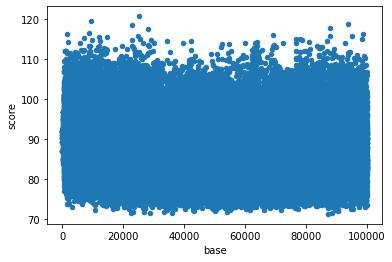

In [16]:
seq_df['base'] = seq_df.index
seq_df.plot.scatter(y = 'score', x = 'base')

Biologically, we can see that our sequence is enriched for guanine and cytosine. I will create a seqlogo diagram from the PWM to see if this finding is supported.

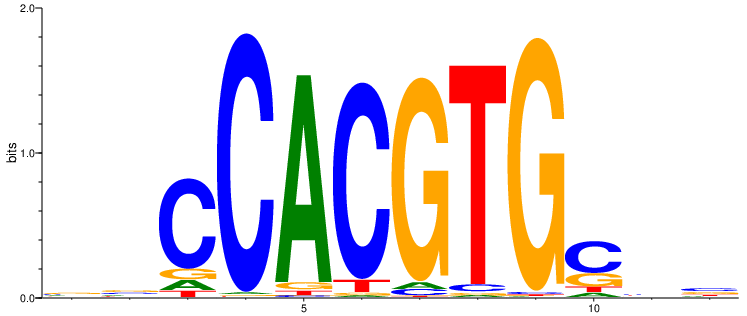

In [58]:
df_CPM = seqlogo.CompletePm(df)
seqlogo.seqlogo(df_CPM, ic_scale = True, format = 'png', size = 'large')

According to the PWM, the bases at the positions with the highest information content are CACGTG in position 4,5,6,7,8,9 of the transcription frame. Cytosine in position 3, and a C or G in position 10 are also relatively important. The sequence identified in this report contains this exact motif. 

# Overview and Improvement

The most likely window of transcription factor binding is the frame starting at base 25075 and extending 12 bases. The sequence of bases in this area is GACCACGTGCTG and it contains exactly the most probable motif predicted by seqlogo diagram above, including the minor contributors at position 3 and 10 in the frame. Understanding locations of TF binding sites, especially for proliferation-controlling proteins like MYC, can help to identify key mechanisms of disease. By locating these binding sites, it is possible to better understand the subsequent mRNA and protein expression in normal healthy cells. Comparing the changes present in cancer at these sites can help to identify the disruption to key protein-DNA interactions and contribute to novel drug development for potential chemotherapeutic intervention.

There are a few places where this analysis could be improved. My solution for identifying the location of the most likely binding site works but is a brute force method that will scale, at best, linearly with data size. This function could be improved by changing the search method. For example, more biological information could be taken into consideration by first making exact matches to promoter regions upstream then only scanning the bases downstream for a predetermined number of bases. Alternatively, by first identifying the most likely sequence (seqlogo diagram above) and making an exact match to motifs that contain those bases instead could help to reduce the number of outputs to those that contain only those six bases in that order. 

Employing a type of random sampling could also lead to a performance improvement, which would help when scaling this problem up from 100,000 bases to the entire chromosome. Sampling twelve random bases to identify areas of higher binding probability then performing a grid search in the subset area around that site would also save time. Random sampling works because the most informative bases will slowly slide into or out of frame, meaning even a partial match will give you a neighborhood address for the most likely position. Following the random search, searching a space of +/- 50 bases in each direction would reduce the number of searches drastically. This method could be optimized by identifying the slope of the grid search output which allows us to use a differentiable equation to identify the local maximum as the most probable binding site. Other avenues of improvement would be take an approach similar to [PWMScan](https://academic.oup.com/bioinformatics/article/34/14/2483/4921176) which parallelizes the whole process to achieve faster performance.